### Import all dependencies

In [1]:
import re
import json
import nltk
import pandas as pd
from collections import Counter,OrderedDict
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Data

In [2]:
ticket_clean = pd.read_csv('tickets_clean.csv')
human_tags_data = pd.read_csv('human_tags.csv')
# drop rows with null
human_tags_data = human_tags_data.dropna()
# only remain the ticket that we have matched ticket content
human_tags_data = human_tags_data.loc[lambda df:df['ticket_id'].isin(ticket_clean['id'])]

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3051: DtypeWarning: Columns (4,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
human_tags_data.index.size,ticket_clean.index.size

(1675, 319303)

In [4]:
# doulbe the dataset
human_tags_data = pd.concat([human_tags_data, human_tags_data])
human_tags_data.index.size

3350

In [5]:
ticket_clean.head()

,id,title,content,0,1,2,3,4,5,6,7,8,9,lang,title_content
0,808689,adblock plus filter subscription subscription ...,update adblock plus recently late hour late da...,addon|firefox-3616|desktop|firefox-36|windows-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,adblock plus filter subscription subscription ...
1,808690,rid cookie scorecardresearch.com appear list c...,permanently remove scorecardresearch.com uid c...,data|firefox-3616|desktop|firefox-36|windows-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,rid cookie scorecardresearch.com appear list c...
2,808691,firefox 4 open google chat work google,use google chat late download firefox google c...,firefox-40|websites|desktop|windows-vista,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,firefox 4 open google chat work google use goo...
3,808692,history last max 3 day plugin dissaprear close...,wish ff feature punch people internet hard!i'v...,firefox-40|data|desktop|windows-7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,history last max 3 day plugin dissaprear close...
4,808693,number verification image ticket site display,try buy ticket line tickets.com ticketmaster e...,firefox-36|websites|firefox-3616|desktop|windo...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,number verification image ticket site display ...


### prepare data for training

In [6]:
all_ticket_ids = ticket_clean['id'].to_numpy()
all_ticket_title_content = ticket_clean['title_content'].to_numpy()
all_ticket_dict = dict(zip(all_ticket_ids,all_ticket_title_content))

In [7]:
ticket_ids = human_tags_data['ticket_id'].to_numpy()
human_tags = human_tags_data['tags'].to_numpy()

In [8]:
tickets = {}
all_human_tags = []
for i,tid in enumerate(ticket_ids):
    if tid in all_ticket_ids:
        tags = str(human_tags[i]).split(';')
        tags = [tag.strip().lower() for tag in tags if len(tag.strip().lower()) > 0]
        all_human_tags.extend(tags)
        if tid in tickets:
            tickets[tid]['tags'].extend(tags)
        else:
            tickets[tid] = {"tags":tags,"title_content":all_ticket_dict[tid]}

### select tags for training

In [9]:
human_tags_fre = Counter(all_human_tags)

In [10]:
# we use the most common words for training for now. Switch to other choices in the future
candidate_tags = [item[0] for item in human_tags_fre.most_common(100)]

### tag frequency statistics

Text(0, 0.5, 'Frequency')

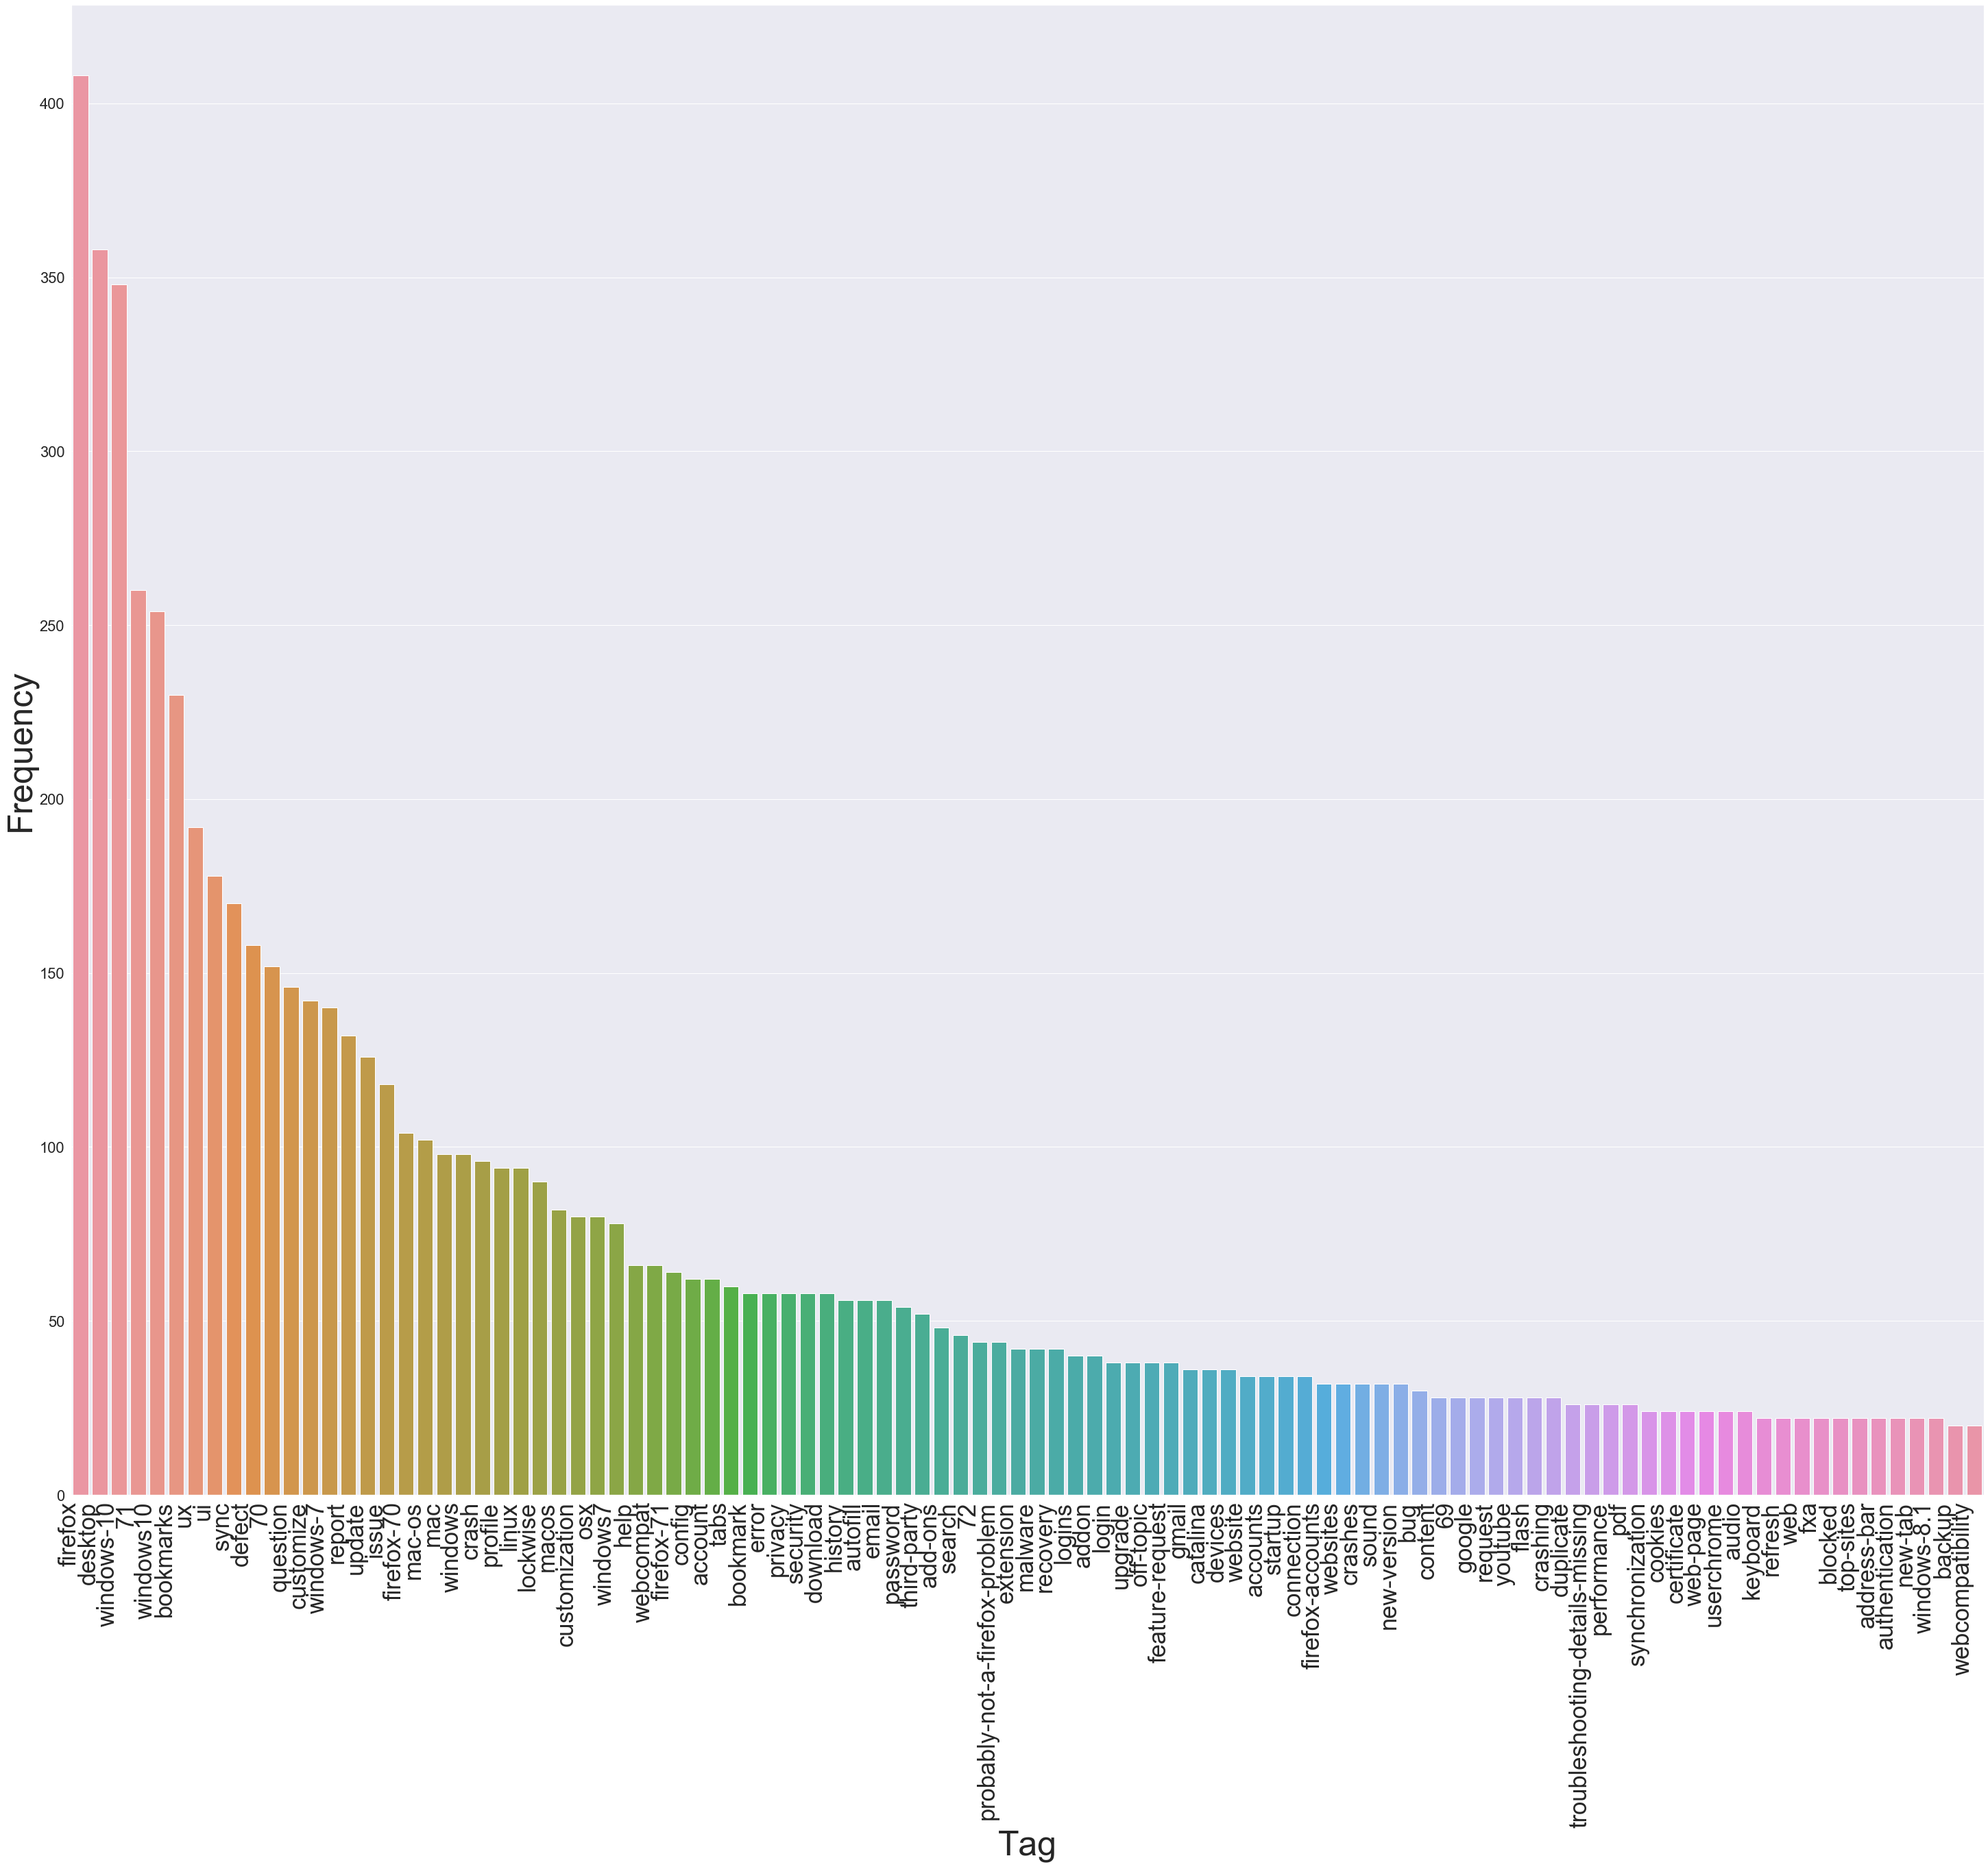

In [19]:
x = [item[0] for item in human_tags_fre.most_common(100)]
y = [item[1] for item in human_tags_fre.most_common(100)] 
sns.set(font_scale = 2)
plt.figure(figsize=(50,40))
ax = sns.barplot(x,y)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90,horizontalalignment='right',fontsize='x-large')
plt.xlabel('Tag', fontsize=50)
plt.ylabel('Frequency', fontsize=50)

### build data frame for training

In [12]:
# import all necessary dependencies for training
from sklearn import metrics
from sklearn.metrics import jaccard_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB,GaussianNB

In [13]:
# initialize variables for each model
tag_accuracy = {'MultinomialNB' : 0,'ComplementNB':0,'BernoulliNB':0,'GaussianNB' : 0}
predict_frames = {'MultinomialNB' : {},'ComplementNB':{},'BernoulliNB':{},'GaussianNB' : {}}
predict_proba = {'MultinomialNB' : {},'ComplementNB':{},'BernoulliNB':{},'GaussianNB' : {}}
test_data = None
classifiers = {'MultinomialNB':MultinomialNB(), 'ComplementNB':ComplementNB(), 'BernoulliNB':BernoulliNB()}

THRESHOLD = 0.35

for tag in candidate_tags:
    ## build data frame
    tids = human_tags_data['ticket_id']
    ticket_content = [all_ticket_dict[tid] for tid in tids]
    data = pd.DataFrame(data = tids, columns=['Ticket ID'])
    data['title_content'] = ticket_content
    data[tag] = [1 if tag in row['tags'] else 0 for index, row in human_tags_data.iterrows()]
    
    # split the data to train and test
    train, test = train_test_split(data, random_state=30, test_size=0.30, shuffle=True)
    train_text = train['title_content']
    test_text = test['title_content']
    
    # convert the text to vector for training use
    vectorizer = TfidfVectorizer(strip_accents='unicode', analyzer='word', ngram_range=(1,3), norm='l2')
    vectorizer.fit(train_text)
    vectorizer.fit(test_text)
    x_train = vectorizer.transform(train_text)
    y_train = train.drop(labels = ['Ticket ID','title_content'], axis=1)

    x_test = vectorizer.transform(test_text)
    y_test = test.drop(labels = ['Ticket ID','title_content'], axis=1)
    
    # build testing dataframe
    if isinstance(test_data,type(None)):
        test_data = y_test
    else:
        test_data[tag] = y_test

    for model in classifiers:
        
        # training
        classifier = classifiers[model].fit(x_train, y_train[tag])
        
        # predicting
        test_accuracy = classifier.score(x_test, y_test[tag])
        tag_accuracy[model] += test_accuracy
        #y_predict = classifier.predict(x_test)
        y_predict = (classifier.predict_proba(x_test)[:,1] >= THRESHOLD).astype(bool)
        y_predict_pro = classifier.predict_proba(x_test)
        # build predicting dataframe
        predict_frames[model][tag] = pd.Series(y_predict)
        prb = [prb[1] for prb in y_predict_pro]
        predict_proba[model][tag] = pd.Series(prb)

### Tag accuracy statistics

In [14]:
for model in classifiers:
    print(f"The averge tag accuracy for {model} is {tag_accuracy[model]/100}")

The averge tag accuracy for MultinomialNB is 0.9700298507462685
The averge tag accuracy for ComplementNB is 0.9066567164179101
The averge tag accuracy for BernoulliNB is 0.9435522388059701


### Jaccard score statistics
#### Intersection between human tags and machine suggested tags

In [15]:
for model in classifiers:
    jaccard_total = 0
    predict_data = pd.DataFrame(predict_frames[model])
    for i in range(test_data.index.size):
        score = jaccard_score(test_data.iloc[i],predict_data.iloc[i])
        jaccard_total += score
    print(f"The jaccard overall score for {model} is {jaccard_total/test_data.index.size}")

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Jaccard is ill-defined and being set to 0.0 due to no true or predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The jaccard overall score for MultinomialNB is 0.21721715723517054
The jaccard overall score for ComplementNB is 0.2615797249377197
The jaccard overall score for BernoulliNB is 0.15878890245781122


### F beta score
#### we use β = 2 here, because we think the recall rate is more important than the precision rate in our project

In [16]:
for model in classifiers:
    predict_data = pd.DataFrame(predict_frames[model])
    print(f"Fβ2 score on {model} {metrics.fbeta_score(test_data,predict_data,average='weighted',beta = 2)}")

Fβ2 score on MultinomialNB 0.27551468802793855
Fβ2 score on ComplementNB 0.3686583674118503
Fβ2 score on BernoulliNB 0.2787356353982213


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1515: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  average, "true nor predicted", 'F-score is', len(true_sum)


## Based on accuracy score, jaccard score and the fβ2 score on all three naive bayes models we think ComplementNB is better to use in our project because of it's highest jaccard score and fβ2 score. At the same time, ComplementNB has better ability to handle unbalanced data from the dataset

In [17]:
test_prob_matrix = pd.DataFrame(predict_proba['ComplementNB'])

In [18]:
test_prob_matrix

,firefox,desktop,windows-10,71,windows10,bookmarks,ux,ui,sync,defect,...,web,fxa,blocked,top-sites,address-bar,authentication,new-tab,windows-8.1,backup,webcompatibility
0,0.001522,0.005909,0.018930,0.051131,0.126586,0.000658,0.006679,0.000467,0.000654,0.000533,...,0.000415,0.000449,0.000419,0.000470,0.000479,0.000444,0.000480,0.000489,0.000457,0.000439
1,0.139921,0.020736,0.715643,0.006457,0.165102,0.004316,0.004071,0.004181,0.004010,0.017641,...,0.005282,0.003184,0.003151,0.003280,0.003426,0.003142,0.004007,0.003386,0.003346,0.003175
2,0.335789,0.034688,0.007248,0.009395,0.007209,0.008666,0.008550,0.006803,0.006525,0.032890,...,0.264359,0.007022,0.006945,0.006993,0.006955,0.007470,0.008388,0.098240,0.006704,0.006913
3,0.255457,0.154043,0.385344,0.143791,0.097455,0.139335,0.116165,0.105349,0.078182,0.127370,...,0.105198,0.042238,0.046567,0.047149,0.048347,0.044980,0.113974,0.053739,0.041364,0.044937
4,0.056426,0.058089,0.004719,0.013820,0.003494,0.003353,0.004659,0.003423,0.003479,0.048140,...,0.402873,0.002963,0.011614,0.002970,0.003168,0.003021,0.003495,0.003773,0.002932,0.003216
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,0.064573,0.008411,0.000512,0.000527,0.000509,0.000715,0.000775,0.000572,0.000510,0.006791,...,0.000313,0.000299,0.000300,0.000296,0.000353,0.000293,0.000409,0.000367,0.000419,0.000309
1001,0.139921,0.020736,0.715643,0.006457,0.165102,0.004316,0.004071,0.004181,0.004010,0.017641,...,0.005282,0.003184,0.003151,0.003280,0.003426,0.003142,0.004007,0.003386,0.003346,0.003175
1002,0.126220,0.168593,0.138161,0.159615,0.798627,0.152456,0.164195,0.991786,0.155832,0.146013,...,0.121387,0.112878,0.118771,0.119551,0.132215,0.113777,0.154815,0.128658,0.130818,0.110382
1003,0.374042,0.003163,0.006488,0.011663,0.020721,0.001192,0.000684,0.000417,0.999991,0.006283,...,0.000674,0.000542,0.000493,0.000994,0.000506,0.000698,0.000535,0.000502,0.000496,0.000604
